## January 2020, BOS 311 Service Requests Analysis

#### The Mayor and his Cabinet have asked the Citywide Analytics Team to look into all cases submitted to BOS: 311 in January 2020 to understand current constituent concerns and performance trends across city departments. 

This is an analysis with observations and potential items for further analysis or action for the Mayor and the Analytics Team to take. Includes data visualizations (charts, tables, maps, etc.) that will help illustrate findings and recommendations.

#### Possible topics for analysis include:

* What general trends do you see in constituent engagement? 
* What services are people requesting? 
* What do you see at a neighborhood level? 
* City Operations: How long does it take to complete a request? 
* How many and what kind of cases were still open at the end of January? 
* What do you see at the departmental-level? 
* What are areas that the City should focus on and what areas has the City done well in?  
* How would you work with departments to improve City services? 
* Are there problems you see in the dataset that would pose challenges to future analyses? 
* How can the City use the information in this dataset—both within City Hall and with the public—to better connect with communities?

### Libraries and module required for the project

In [1]:
import pandas as pd
import numpy as np 
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from AssociationAnalysis import cases
from sklearn import preprocessing 


### Extracting publicly available dataset

In [2]:
#Data set URL
url = 'https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/6ff6a6fd-3141-4440-a880-6f60a37fe789/download/tmpt1d4qk7n.csv'
bdata = pd.read_csv(url, usecols = ['case_enquiry_id', 'open_dt', 'closed_dt', 'ontime', 'case_status', 'case_title',
                                    'subject', 'reason', 'type', 'queue', 'department', 'submittedphoto', 
                                    'closedphoto', 'fire_district', 'city_council_district', 'neighborhood',
                                    'neighborhood_services_district', 'ward', 'location_zipcode', 'source'], header = 0,
                    low_memory = True)

#The original data types of the data frame stored in variable original_Dtypes
original_Dtypes = bdata.dtypes


### Data cleaning using fillna() and replace() with regex, and astype() to change the column datatype
#### Made use of cat.add_categories() to add a category; this is to resolve missing value in a column of Category type

In [3]:
#Setting the image url to true, only to get the count of submissions
bdata.closedphoto.replace('^https:.*', 'True', regex = True, inplace = True)
bdata.submittedphoto.replace('^https:.*', 'True', regex = True, inplace = True)

#Filling the NaN values in columns submittedphoto and closedphoto with False
try:
    bdata['submittedphoto'] = pd.Categorical(bdata.submittedphoto)
    bdata['submittedphoto'] = bdata['submittedphoto'].cat.add_categories('False')
except:
    pass
bdata['submittedphoto'].fillna('False', inplace = True)

try:
    bdata['closedphoto'] = pd.Categorical(bdata.closedphoto)
    bdata['closedphoto'] = bdata['closedphoto'].cat.add_categories('False')
except:
    pass
bdata['closedphoto'].fillna('False', inplace = True)

#Removing Ward n from the column ward
bdata.ward.replace('^Ward ', '', regex = True, inplace = True)
bdata.ward.replace(' ', 0, inplace = True)

#Managing missing values from the column location_zipcode
bdata['location_zipcode'].fillna('No Zip code', inplace = True)
bdata.location_zipcode.replace(' ', 0, inplace=True)


#Restructure neighborhood_services_district column; this will be used with apriori()
bdata.neighborhood_services_district.replace(' ', 0, inplace = True)
bdata['neighborhood_services_district'].fillna(0, inplace = True)
bdata['neighborhood_services_district'] = bdata['neighborhood_services_district'].astype('int32')

#Converting the columns open_dt and closed_dt, from object to date
bdata['open_dt'] = pd.to_datetime(bdata['open_dt'])
bdata['closed_dt'] = pd.to_datetime(bdata['closed_dt'])

#Converted the below columns from object to categories
bdata['ontime'] = pd.Categorical(bdata.ontime)
bdata['case_status'] = pd.Categorical(bdata.case_status)
bdata['subject'] = pd.Categorical(bdata.subject)
#bdata['reason'] = pd.Categorical(bdata.subject)
#bdata['neighborhood'] = pd.Categorical(bdata.subject)
bdata['type'] = pd.Categorical(bdata.type)
bdata['queue'] = pd.Categorical(bdata.queue)
bdata['location_zipcode'] = pd.Categorical(bdata.location_zipcode)
bdata['closedphoto'] = pd.Categorical(bdata.closedphoto)

#Managing missing values in the columns fire_district and city_council_district
#fire and city are the variables created to be used while ploting histogram
bdata['fire_district'] = pd.Categorical(bdata.fire_district)
try:
    bdata['fire_district'] = bdata['fire_district'].cat.add_categories(0)
except:
    pass
bdata['fire_district'].fillna(0, inplace=True)
bdata.fire_district.replace(' ', 0, inplace=True)
fire = bdata['fire_district']
fire = fire.astype('int32')

#Cleaning the column city_council_district
bdata['city_council_district'] = pd.Categorical(bdata.city_council_district)
try:
    bdata['city_council_district'] = bdata['city_council_district'].cat.add_categories(0)
except:
    pass
bdata['city_council_district'].fillna(0, inplace=True)
bdata.city_council_district.replace(' ', 0, inplace=True)
city = bdata['city_council_district']
city = city.astype('int32')


try:
    bdata['neighborhood'] = pd.Categorical(bdata.neighborhood)
    bdata['neighborhood'] = bdata['neighborhood'].cat.add_categories('None')
except:
    pass
bdata.neighborhood.replace(' ', 'None', inplace=True)
bdata['neighborhood'].fillna('None', inplace = True)


try:
    bdata['ward'] = pd.Categorical(bdata.ward)
    bdata['ward'] = bdata['ward'].cat.add_categories('None')
except:
    pass
bdata.ward.replace(' ', 'None', inplace=True)
bdata['ward'].fillna('None', inplace = True)

try:
    bdata['source'] = pd.Categorical(bdata.source)
except:
    pass

#Column case_title will be a string type
bdata['case_title'] = bdata.case_title.astype('string')

#converted_Dtypes is a variable that holds datatype of the data frame after converting the column types
converted_Dtypes = bdata.dtypes


In [4]:
print('Datatypes of data frame bdata before convertion \n\n', original_Dtypes, '\n-------' '\n\n Datatypes of data frame bdata after convertion \n\n', converted_Dtypes)

Datatypes of data frame bdata before convertion 

 case_enquiry_id                     int64
open_dt                            object
closed_dt                          object
ontime                             object
case_status                        object
case_title                         object
subject                            object
reason                             object
type                               object
queue                              object
department                         object
submittedphoto                     object
closedphoto                        object
fire_district                      object
city_council_district              object
neighborhood                       object
neighborhood_services_district     object
ward                               object
location_zipcode                  float64
source                             object
dtype: object 
-------

 Datatypes of data frame bdata after convertion 

 case_enquiry_id                   

### General trends in constituent engagement

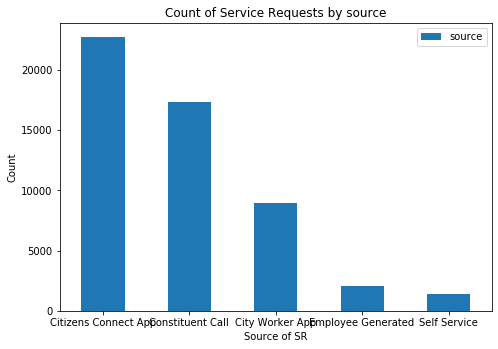

In [5]:
source = bdata['source'].value_counts()
source.cumsum()
source_plt = plt.figure() 
source_ax = source_plt.add_axes([0,0,1,1])
source.plot(kind = 'bar')
source_ax.set_title('Count of Service Requests by source')
source_ax.set_xlabel('Source of SR')
source_ax.set_ylabel('Count')
plt.xticks(rotation='horizontal')
plt.legend(loc='best')
plt.show()

### Ontime resolution, case status by case subject

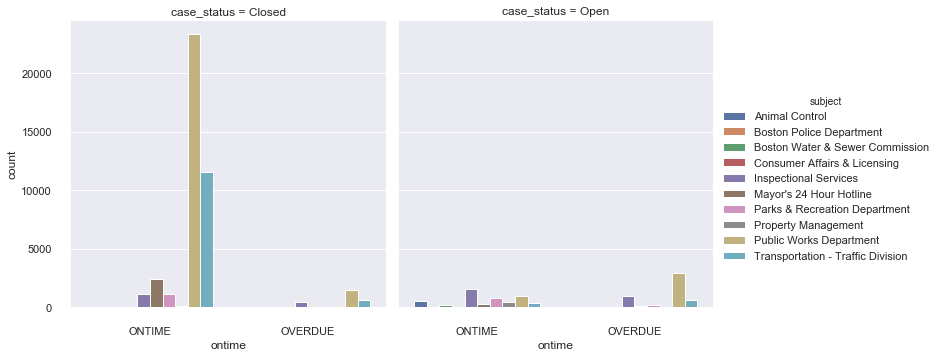

In [6]:
sns.set(style="whitegrid", color_codes=True)
sns.set(rc={'figure.figsize':(8,8)})
sns.catplot(x='ontime', hue='subject', col='case_status', data=bdata, kind='count')
sns.despine(offset=10, trim=True)

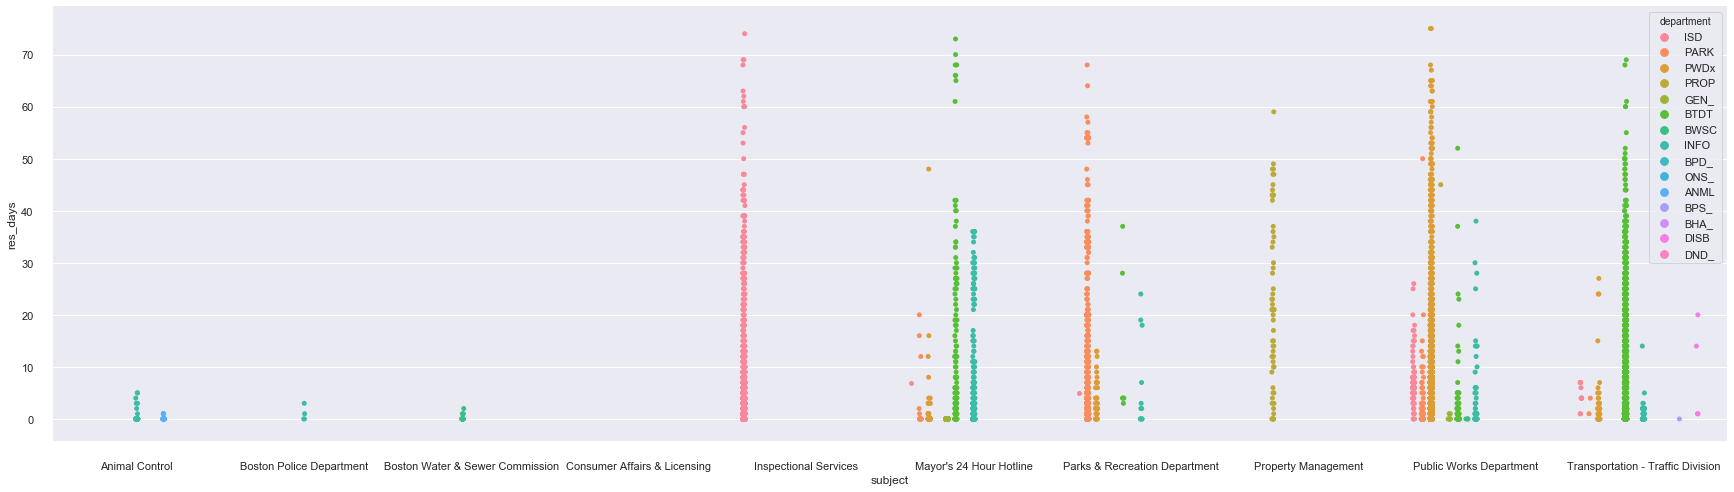

In [7]:
bdata['res_days'] = (bdata['closed_dt'] - bdata['open_dt']).dt.days
sns.set(rc={'figure.figsize':(30,8)})
sns.stripplot(x='subject', y='res_days', data=bdata, jitter=True, hue='department', dodge=True)
sns.despine(offset=10, trim=True)

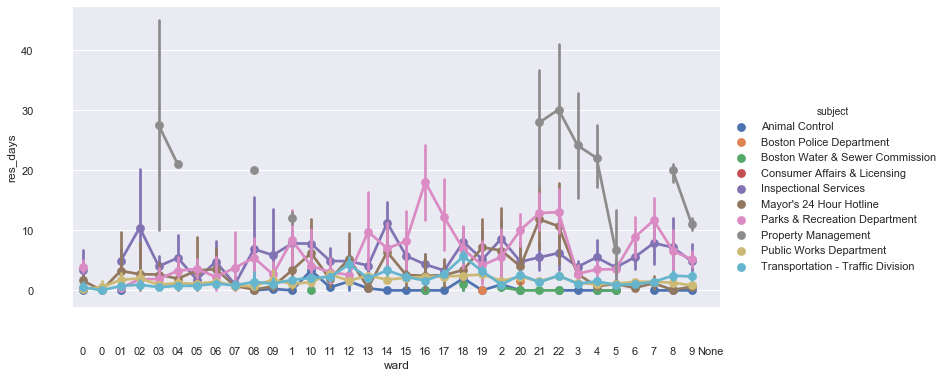

In [8]:
bdata['res_days'] = (bdata['closed_dt'] - bdata['open_dt']).dt.days
sns.factorplot(x='ward', y='res_days', data=bdata, hue='subject', aspect=40/20)
sns.despine(offset=30, trim=True)

#### Max, Min, and Mean number of days for Service request resolution?

In [9]:
#Used from the formula, Number of days for resolution = Closed date - Open date
bdata['res_days'].describe()

count    42364.000000
mean         2.137168
std          5.994808
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         75.000000
Name: res_days, dtype: float64

### At the Neighborhood level?

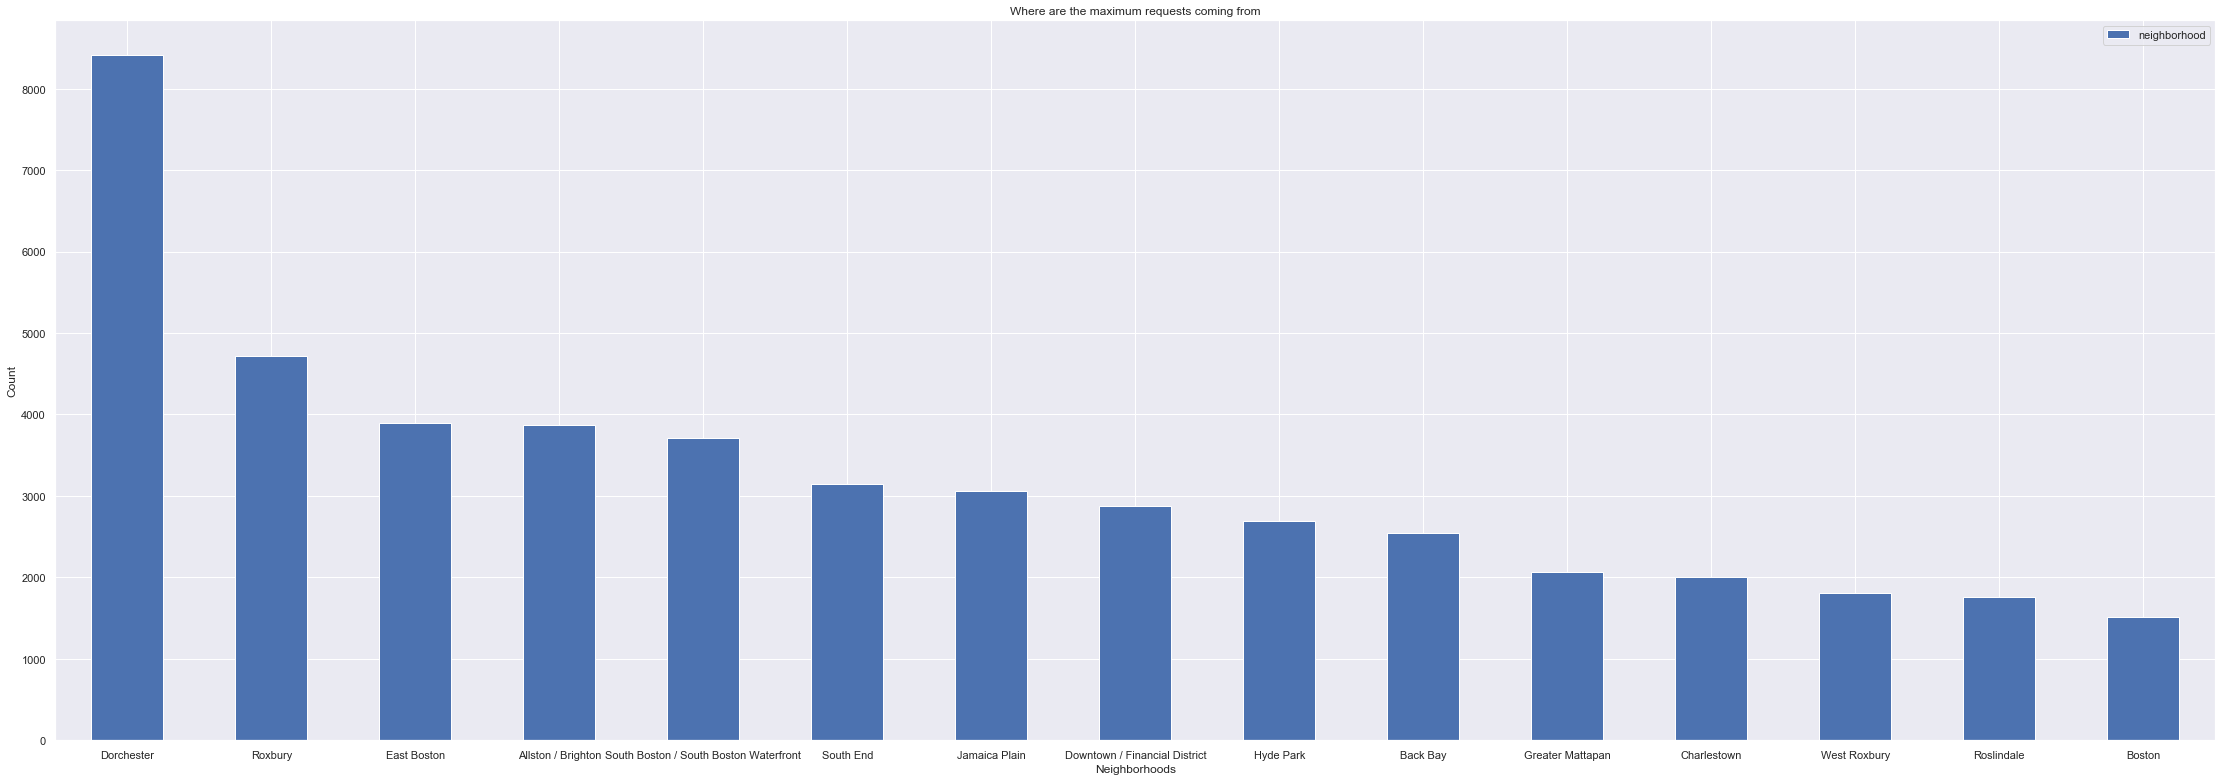

Top 15 Neighborhoods


Dorchester                                8418
Roxbury                                   4712
East Boston                               3895
Allston / Brighton                        3876
South Boston / South Boston Waterfront    3708
South End                                 3148
Jamaica Plain                             3061
Downtown / Financial District             2881
Hyde Park                                 2687
Back Bay                                  2542
Greater Mattapan                          2070
Charlestown                               2002
West Roxbury                              1807
Roslindale                                1754
Boston                                    1516
Name: neighborhood, dtype: int64

In [10]:
neighbor = bdata['neighborhood'].value_counts(sort = True, dropna = True)
neighbor = neighbor.iloc[:15]
neighbor_plt = plt.figure(figsize = [30,10]) 
neighbor_ax = neighbor_plt.add_axes([0,0,1,1])
neighbor.plot(kind = 'bar')
neighbor_ax.set_title('Where are the maximum requests coming from')
neighbor_ax.set_xlabel('Neighborhoods')
neighbor_ax.set_ylabel('Count')
plt.xticks(rotation='horizontal')
plt.legend(loc='best')
plt.show()
print('Top 15 Neighborhoods')
neighbor

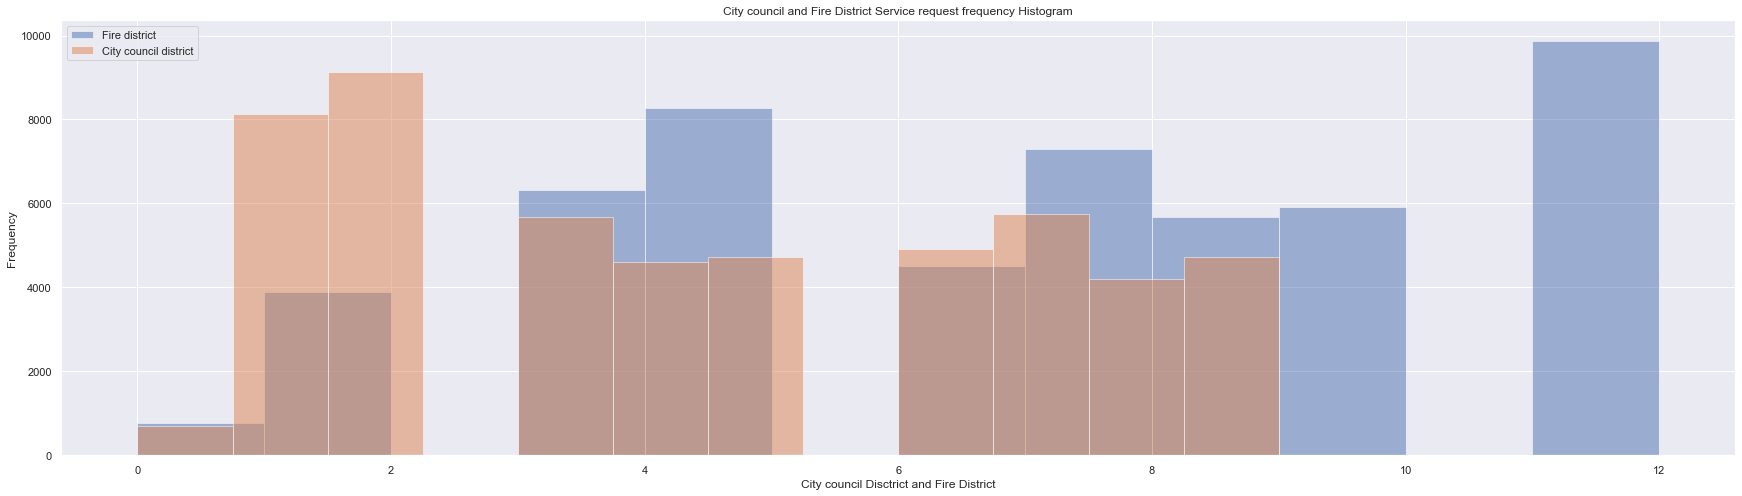

In [11]:
#Histogram to show Service Request frequency from City council and Fire council districts
plt.hist(fire, bins = 12, alpha = 0.5, label = 'Fire district')
plt.hist(city, bins = 12, alpha = 0.5, label = 'City council district')
plt.xlabel('City council Disctrict and Fire District')
plt.ylabel('Frequency')
plt.title('City council and Fire District Service request frequency Histogram')
plt.legend(loc='best')
plt.show()

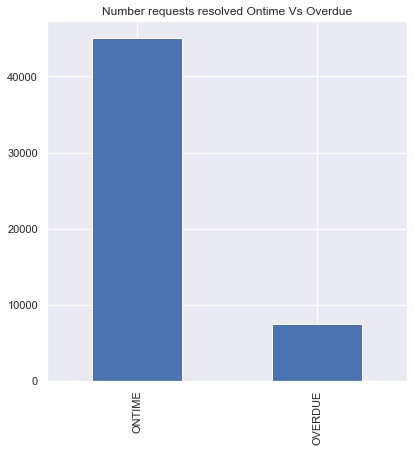

Resolution


ONTIME     45024
OVERDUE     7493
Name: ontime, dtype: int64

In [12]:
ontime = bdata['ontime'].value_counts(sort = True, dropna = True)
ontime_plt = plt.figure(figsize = [5,5]) 
ontime_ax = ontime_plt.add_axes([0,0,1,1])
ontime.plot(kind = 'bar')
plt.title('Number requests resolved Ontime Vs Overdue')
plt.show()
print('Resolution')
ontime

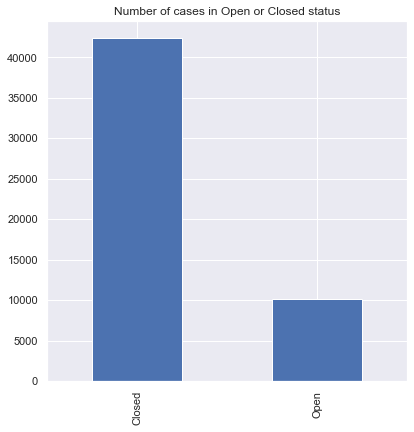

Service Request Status


Closed    42364
Open      10153
Name: case_status, dtype: int64

In [13]:
status = bdata['case_status'].value_counts(sort = True, dropna = True)
status_plt = plt.figure(figsize = [5,5]) 
status_ax = status_plt.add_axes([0,0,1,1])
status.plot(kind = 'bar')
plt.title('Number of cases in Open or Closed status')
plt.show()
print('Service Request Status')
status

## Association Analysis (Neighborhood level) using mlxtend

In [14]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

### Restructuring the columns

In [15]:
bdata['reason'] = bdata['reason'].astype('str')
bdata['reason'] = bdata['reason'].str.strip()
bdata['department'] = bdata['department'].astype('str')
closeCase = (bdata[bdata['case_status'] == 'Closed'].groupby(['department', 'reason'])
             ['neighborhood_services_district'].sum().unstack().reset_index().fillna(0).set_index('department'))


In [16]:
closeCase_collection =  closeCase.applymap(cases)

frequent_cases = apriori(closeCase_collection, min_support = 0.01, use_colnames = True)


### What see at the departmental-level?

In [17]:
closeCase_collection

reason,Abandoned Bicycle,Administrative & General Requests,Air Pollution Control,Animal Issues,Boston Bikes,Building,Catchbasin,Cemetery,Code Enforcement,Employee & General Comments,...,Parking Complaints,Recycling,Sanitation,Sidewalk Cover / Manhole,Signs & Signals,Street Cleaning,Street Lights,Traffic Management & Engineering,Trees,Weights and Measures
department,,,,,,,,,,,,,,,,,,,,,
ANML,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BPS_,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BTDT,1,1,0,0,1,0,0,0,1,1,...,1,0,0,0,1,1,1,1,1,0
BWSC,0,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
DISB,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
GEN_,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
INFO,0,1,1,1,0,0,0,0,1,1,...,0,0,1,0,1,1,1,1,1,0
ISD,0,1,0,0,0,1,0,0,1,0,...,0,0,1,0,1,1,0,0,0,1
PARK,0,1,0,0,0,0,0,0,1,1,...,0,0,0,0,1,1,0,0,1,0


In [18]:
frequent_cases = frequent_cases[frequent_cases['support'] >= 0.5]
frequent_cases

,support,itemsets
1,0.636364,(Administrative & General Requests)
7,0.545455,(Code Enforcement)
9,0.636364,(Enforcement & Abandoned Vehicles)
15,0.636364,(Highway Maintenance)
26,0.545455,(Signs & Signals)
27,0.545455,(Street Cleaning)
55,0.545455,"(Administrative & General Requests, Enforcemen..."
60,0.545455,"(Administrative & General Requests, Highway Ma..."
70,0.545455,"(Administrative & General Requests, Signs & Si..."
147,0.545455,"(Code Enforcement, Street Cleaning)"


In [19]:
likely_conditions = association_rules(frequent_cases, metric = 'lift', min_threshold = 1)
likely_conditions.sort_values(by=['confidence'], ascending = False, inplace = True)
likely_conditions[(likely_conditions['lift'] >= 1) & (likely_conditions['confidence'] >= 0.7)]


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
5,(Signs & Signals),(Administrative & General Requests),0.545455,0.636364,0.545455,1.000000,1.571429,0.198347,inf
6,(Code Enforcement),(Street Cleaning),0.545455,0.545455,0.545455,1.000000,1.833333,0.247934,inf
7,(Street Cleaning),(Code Enforcement),0.545455,0.545455,0.545455,1.000000,1.833333,0.247934,inf
9,(Signs & Signals),(Enforcement & Abandoned Vehicles),0.545455,0.636364,0.545455,1.000000,1.571429,0.198347,inf
10,"(Administrative & General Requests, Enforcemen...",(Signs & Signals),0.545455,0.545455,0.545455,1.000000,1.833333,0.247934,inf
11,"(Administrative & General Requests, Signs & Si...",(Enforcement & Abandoned Vehicles),0.545455,0.636364,0.545455,1.000000,1.571429,0.198347,inf
12,"(Enforcement & Abandoned Vehicles, Signs & Sig...",(Administrative & General Requests),0.545455,0.636364,0.545455,1.000000,1.571429,0.198347,inf
15,(Signs & Signals),"(Administrative & General Requests, Enforcemen...",0.545455,0.545455,0.545455,1.000000,1.833333,0.247934,inf
0,(Administrative & General Requests),(Enforcement & Abandoned Vehicles),0.636364,0.636364,0.545455,0.857143,1.346939,0.140496,2.545455
1,(Enforcement & Abandoned Vehicles),(Administrative & General Requests),0.636364,0.636364,0.545455,0.857143,1.346939,0.140496,2.545455


In [23]:

enc = preprocessing.LabelEncoder()
bdata['case_status'] = enc.fit_transform(bdata['case_status'])
bdata['subject'] = enc.fit_transform(bdata['subject'])
bdata['reason'] = enc.fit_transform(bdata['reason'])
bdata['ontime'] = enc.fit_transform(bdata['ontime'])
bdata['type'] = enc.fit_transform(bdata['type'])
bdata['queue'] = enc.fit_transform(bdata['queue'])
bdata['fire_district'] = enc.fit_transform(fire)
bdata['city_council_district'] = enc.fit_transform(city)
bdata['department'] = enc.fit_transform(bdata['department'])
bdata['neighborhood'] = enc.fit_transform(bdata['neighborhood'])
bdata['neighborhood_services_district'] = enc.fit_transform(bdata['neighborhood_services_district'])
bdata['res_days'] = enc.fit_transform(bdata['res_days'])
bdata['location_zipcode'] = bdata['location_zipcode'].astype('str')
bdata['location_zipcode'] = enc.fit_transform(bdata['location_zipcode'])
bdata['source'] = enc.fit_transform(bdata['source'])


In [25]:
fields = [field for field in bdata.columns if field not in ['case_enquiry_id', 'open_dt', 'closed_dt', 'case_title',
                                                            'case_status', 'submittedphoto', 'closedphoto']]
filtered_data = bdata[fields]
target = bdata['case_status']


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
data_train, data_test, target_train, target_test = train_test_split(filtered_data,target, test_size = 0.20, random_state = 10)


In [27]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

predgnb = gnb.fit(data_train, target_train).predict(data_test)
print('Navie Bayes model accuracy: ', accuracy_score(target_test, predgnb, normalize=True))

Navie Bayes model accuracy:  0.9765803503427266


In [28]:
from sklearn.svm import LinearSVC
lsvc = LinearSVC(random_state=0)

predlsvc = lsvc.fit(data_train, target_train).predict(data_test)
print('Linear Support Vector Classifier model accuracy: ', accuracy_score(target_test, predlsvc, normalize=True))

Linear Support Vector Classifier model accuracy:  0.9996191926884996


In [29]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier(n_neighbors=3)
predknc = knc.fit(data_train, target_train).predict(data_test)
print('K Neighbors Classifier model accuracy: ', accuracy_score(target_test, predknc, normalize=True))

K Neighbors Classifier model accuracy:  1.0


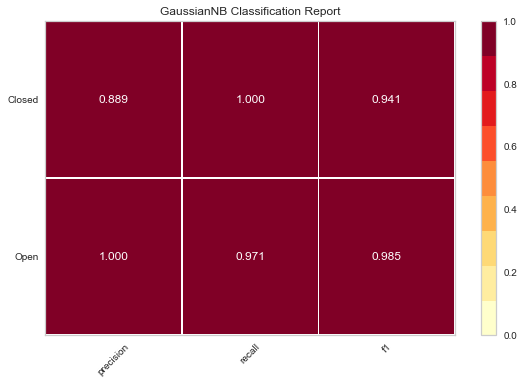

In [30]:
from yellowbrick.classifier import ClassificationReport
ocgnb = ClassificationReport(gnb, classes=['Open','Closed'])
ocgnb.fit(data_train, target_train)
ocgnb.score(data_test, target_test)
gnbacc = ocgnb.poof() 

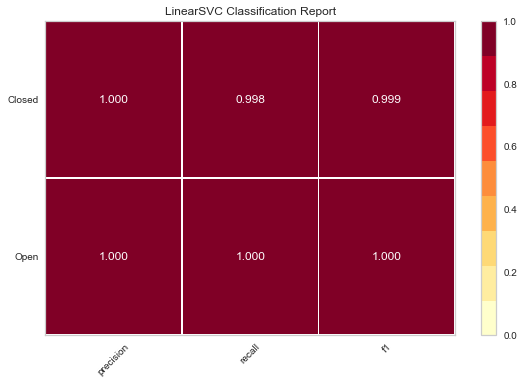

In [31]:
oclsvc = ClassificationReport(lsvc, classes=['Open','Closed'])
oclsvc.fit(data_train, target_train)
oclsvc.score(data_test, target_test)
lsvcacc = oclsvc.poof()

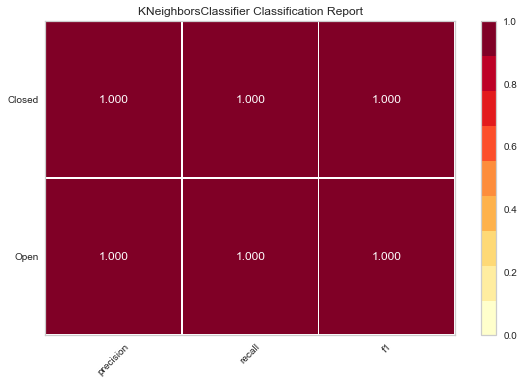

In [32]:
ocknc = ClassificationReport(knc, classes=['Open','Closed'])
ocknc.fit(data_train, target_train) # Fit the training data to the visualizer
ocknc.score(data_test, target_test) # Evaluate the model on the test data
kncacc = ocknc.poof()